In [24]:
from matplotlib import pyplot as plt
import numpy as np
import pylhe
import pandas as pd

In [25]:
defaultPars = {'figure.figsize': (5, 4),
               'lines.markersize' : 4,
               'axes.titlesize' : 13,
               'font.size' : 13,
               'axes.labelsize' : 16,
               'xtick.labelsize' : 13,
               'ytick.labelsize' : 13,
               'legend.fontsize' : 10,
               "text.usetex": True,
               "font.family": "sans-serif",
               "font.sans-serif": ["Helvetica"],
               'font.family':'Times New Roman', 
               'font.serif':'Times New Roman',
               "savefig.dpi" : 300,
               'contour.linewidth' : 2.0,
               'lines.linewidth' : 2.0,
               'axes.grid' : True,
               'grid.linewidth' : 0.5,
               'grid.color' : 'lightgray',
               'axes.axisbelow' : True
               }
plt.rcParams.update(defaultPars)

In [26]:
def add(ptcList,**kwargs):
    pDict = {'id' : 0, 'status' : 1, "mother1" : -1, "mother2" : -1, "color1" : 0, "color2": 0, "m" : -1, "lifetime" : -1, "spin" : -1}
    for attr in ['e','px','py','pz']:
        pDict[attr] =  sum([getattr(ptc,attr) for ptc in ptcList])

    ptcTot = pylhe.LHEParticle(**pDict)
    ptcTot.m = np.sqrt(np.round(ptcTot.e**2 - ptcTot.px**2 - ptcTot.py**2 - ptcTot.pz**2,3))
    for k,v in kwargs.items():
        setattr(ptcTot,k,v)

    return ptcTot


In [27]:
files = {
         'without spin corr.' : './pp2Sd/Events/run_02_decayed_1/unweighted_events.lhe.gz',
        #  'with spin corr.' : './pp2Sd/Events/run_02_decayed_4/unweighted_events.lhe.gz',
        #  'decay' : './pp2chi0chi0Decays/Events/run_01/unweighted_events.lhe.gz',
         'full' : './pp2chi0chi0/Events/run_04/unweighted_events.lhe.gz',
         }

pT = {}
eta = {}
dR = {}
cols = ['label',r'$E(\gamma_1)$ (GeV)', r'$E(\gamma_2)$ (GeV)',r'$p_T(\gamma_1)$ (GeV)',r'$p_T(\gamma_2)$ (GeV)',
        r'$\eta(\gamma_1)$',r'$\eta(\gamma_2)$',
        r'$\Delta R(\gamma_1,\gamma_2)$',r'$\Delta \phi (\gamma_1,\gamma_2)$',r'$E_{T}^{miss}$ (GeV)',
        r'$\Delta \phi(\gamma_1,E_{T}^{miss})$',r'$\Delta \phi(\gamma_2,E_{T}^{miss})$', r'$m_{\rm Tot}$ (GeV)']

nmax = 25000
dataList = []
for label,f in files.items():    
    ievt = 0
    for event in pylhe.read_lhe_with_attributes(f):
        ievt += 1
        if nmax > 0 and ievt > nmax:
            break
        photons = [ptc for ptc in event.particles if abs(ptc.id) == 22]
        chi0s = [ptc for ptc in event.particles if abs(ptc.id) == 5000022]
        if len(photons) != 2:
            print(f'{len(photons)} photons found in {f}!')
            break
        if len(chi0s) != 2:
            print(f'{len(chi0s)} chi0 found in {f}!')
            break
        metP = add(chi0s)
        # Reconstruct the total momentum in the event total particle = chi0[0]+chi0[1]+photons[0]+photons[1]
        totalP = add(chi0s+photons)

        for p in photons+chi0s+[metP,totalP]:
            p.pT = np.sqrt(p.px**2 + p.py**2)
            p.eta = (1./2.)*np.log((p.e+p.pz)/(p.e-p.pz))
            p.phi = np.arctan2(p.py,p.px)
            m0sq = np.round(p.e**2 - p.px**2 - p.py**2 - p.pz**2,3)
            if m0sq < 0.0:
                print(m0sq,p.id)
            p.m0 = np.sqrt(m0sq) # Round number in case of small numerical differences

        photons = sorted(photons, key = lambda ptc: ptc.pT,reverse=True)
        chi0s = sorted(chi0s, key = lambda ptc: ptc.pT,reverse=True)

        # Create data for event:
        # ['label','E(a1)', 'E(a2)','pT(a1)','pT(a2)','eta(a1)','eta(a2)','dR(a1,a2)','dphi(a1,a2)','MET','dphi(a1,MET)','dphi(a2,MET)', 'mtot']
        dR = np.sqrt((photons[0].phi-photons[1].phi)**2 + (photons[0].eta-photons[1].eta)**2)
        metV =[chi0s[0].px+chi0s[1].px,(chi0s[0].py+chi0s[1].py)]
        data = [label,photons[0].e,photons[1].e,photons[0].pT,photons[1].pT,photons[0].eta,photons[1].eta,dR,np.abs(photons[0].phi-photons[1].phi),
                metP.pT,np.abs(photons[0].phi-metP.phi),np.abs(photons[1].phi-metP.phi),totalP.m0
                ]
        dataList.append(data)
    
df = pd.DataFrame(columns=cols,data=dataList)
        

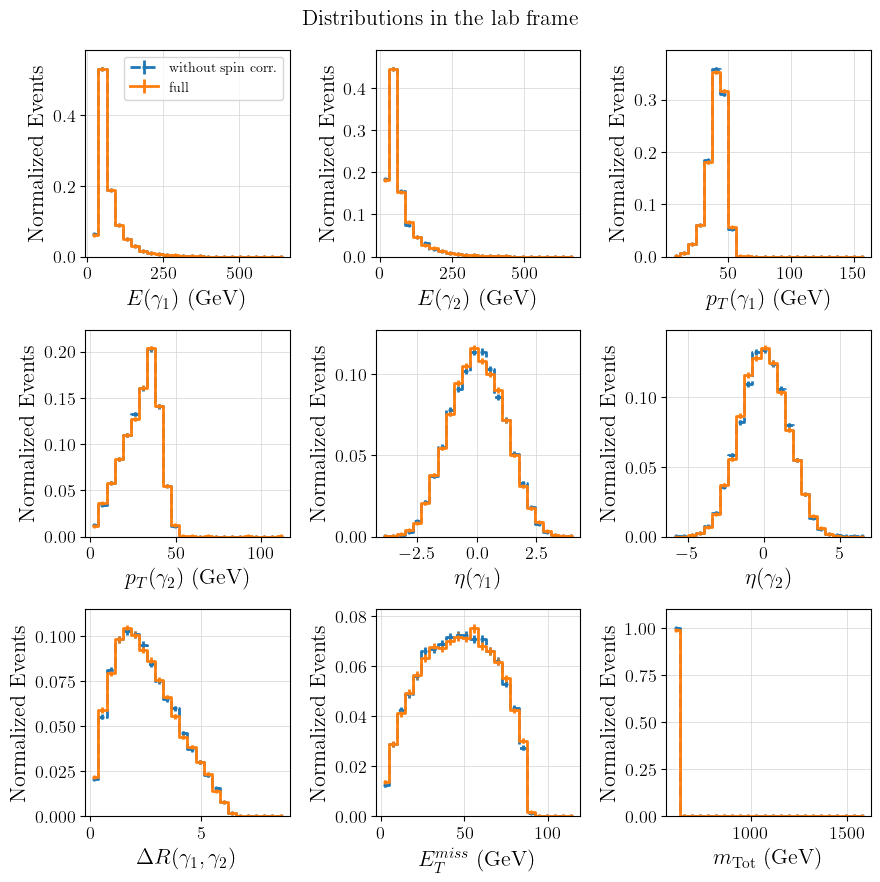

In [28]:
plot_variables = [c for c in df.columns if c not in ['label']]
plot_variables = [c for c in plot_variables[:] if 'phi' not in c]
plot_variables = [c for c in plot_variables[:] if r'm(\chi_0' not in c]


ncols = 3
nrows = int((len(plot_variables)-1)/ncols)
while nrows*ncols < len(plot_variables):
    nrows += 1
fig,axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(3*ncols,3*nrows))
axarr = np.array(axes).reshape(-1)




for i,var in enumerate(plot_variables):
    v_max, v_min = df[var].max(),df[var].min()
    bins = np.linspace(v_min,v_max,25)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax = axarr[i]
    ymax = 0.0
    for label in df['label'].unique():
        if 'full' in label:
            ls = 'solid'
        else:
            ls = 'dashed'
        data = df[df['label'] == label]
        ## Filter for on-shell events:
        # data = data[np.abs(df[r'$m(\chi_1 (1))$ (GeV)']-df[r'$m(\chi_1 (1))$ (GeV)'].mean()) < 1.0]
        # data = data[np.abs(df[r'$m(\chi_1 (2))$ (GeV)']-df[r'$m(\chi_1 (2))$ (GeV)'].mean()) < 1.0]
        # data = data[np.abs(df[r'$m(S)$ (GeV)']-df[r'$m(S)$ (GeV)'].mean()) < 1.0]
        y,_ = np.histogram(data[var], bins=bins)
        yerr = np.sqrt(y)
        norm = sum(y)
        y = y/norm
        ymax = max(ymax,y.max())
        yerr = yerr/norm
        ax.errorbar(bin_centers,y,yerr = yerr,marker = '.',drawstyle = 'steps-mid',
                 label=label,linewidth=2,linestyle=ls)
    ax.set_xlabel(var)
    ax.set_ylabel('Normalized Events')
    if i == 0:
        ax.legend()
    ax.set_ylim(0.0,1.1*ymax)
    # ax.set_yscale('log')
fig.suptitle("Distributions in the lab frame")
plt.tight_layout()
plt.show()

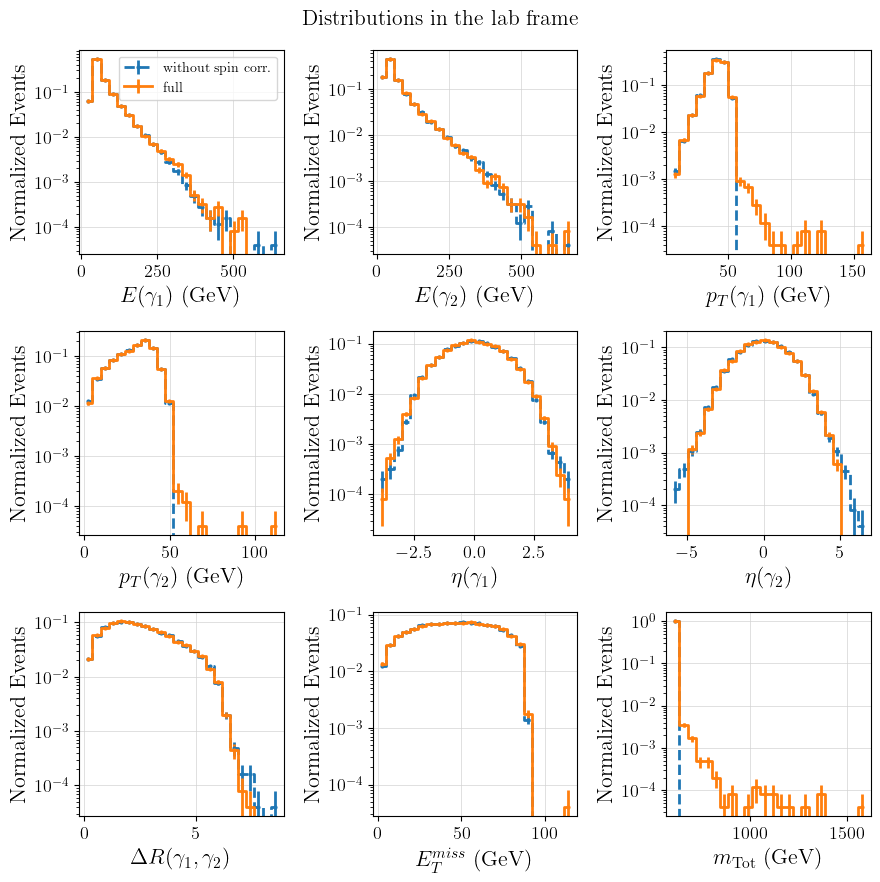

In [29]:
plot_variables = [c for c in df.columns if c not in ['label']]
plot_variables = [c for c in plot_variables[:] if 'phi' not in c]
plot_variables = [c for c in plot_variables[:] if r'm(\chi_0' not in c]


ncols = 3
nrows = int((len(plot_variables)-1)/ncols)
while nrows*ncols < len(plot_variables):
    nrows += 1
fig,axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(3*ncols,3*nrows))
axarr = np.array(axes).reshape(-1)




for i,var in enumerate(plot_variables):
    v_max, v_min = df[var].max(),df[var].min()
    bins = np.linspace(v_min,v_max,25)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax = axarr[i]
    ymax = 0.0
    for label in df['label'].unique():
        if 'full' in label:
            ls = 'solid'
        else:
            ls = 'dashed'
        data = df[df['label'] == label]
        ## Filter for on-shell events:
        # data = data[np.abs(df[r'$m(\chi_1 (1))$ (GeV)']-df[r'$m(\chi_1 (1))$ (GeV)'].mean()) < 1.0]
        # data = data[np.abs(df[r'$m(\chi_1 (2))$ (GeV)']-df[r'$m(\chi_1 (2))$ (GeV)'].mean()) < 1.0]
        # data = data[np.abs(df[r'$m(S)$ (GeV)']-df[r'$m(S)$ (GeV)'].mean()) < 1.0]
        y,_ = np.histogram(data[var], bins=bins)
        yerr = np.sqrt(y)
        norm = sum(y)
        y = y/norm
        ymax = max(ymax,y.max())
        yerr = yerr/norm
        ax.errorbar(bin_centers,y,yerr = yerr,marker = '.',drawstyle = 'steps-mid',
                 label=label,linewidth=2,linestyle=ls)
    ax.set_xlabel(var)
    ax.set_ylabel('Normalized Events')
    if i == 0:
        ax.legend()
    # ax.set_ylim(0.0,1.1*ymax)
    ax.set_yscale('log')
fig.suptitle("Distributions in the lab frame")
plt.tight_layout()
plt.show()